# First Tryout - Workflow

1. **Preparing the audio data**:
    - Loading audio files from the `dataset` folder.
    - Normalizing the loudness of the audio files.
    - Downsampling the audio for efficiency.
2. **Extracting features suitable for RNN input**:
    - Converting audio signals into sequences of features (MFCCs).
3. **Building and training an RNN model**:
    - Using an RNN-based autoencoder to learn patterns in the data.

Import Necessary Libraries

In [1]:
import os
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

## Preparing the audio data

1. Define Audio Preprocessing Functions

In [2]:
def normalize_loudness(y):
    """Normalize audio to have consistent loudness."""
    rms = np.sqrt(np.mean(y**2))
    if rms > 0:
        y = y / rms
    return y

def load_and_preprocess_audio(file_path, target_sr=16000):
    """Load and preprocess audio file."""
    y, sr = librosa.load(file_path, sr=None)
    # Downsample if necessary
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    # Normalize loudness
    y = normalize_loudness(y)
    return y


## Preparing the audio data

2. Load Audio Files from the folder `dataset`



In [3]:
# Path to your dataset folder
dataset_path = 'dataset'

# Get list of audio files
audio_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.wav')]

# Preprocess and store audio data
audio_data = []

for file in tqdm(audio_files, desc='Loading and preprocessing audio files'):
    y = load_and_preprocess_audio(file)
    audio_data.append(y)


Loading and preprocessing audio files:   0%|          | 0/615 [00:00<?, ?it/s]

## Extracting features suitable for RNN input

3. Define Feature Extraction Function

In [4]:
def extract_mfcc_features(y, sr=16000, n_mfcc=40):
    """Extract MFCC features from audio signal."""
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = mfcc.T  # Shape: (Time steps, n_mfcc)
    return mfcc

## Extracting features suitable for RNN input

4. Extract Features from All Audio Data

In [5]:
# List to hold feature sequences
feature_sequences = []

for y in tqdm(audio_data, desc='Extracting features'):
    features = extract_mfcc_features(y)
    feature_sequences.append(features)

Extracting features:   0%|          | 0/615 [00:00<?, ?it/s]

## Building and training an RNN model

5. Prepare Data for PyTorch and Create a Custom Dataset

In [6]:
class AudioDataset(Dataset):
    def __init__(self, feature_sequences):
        self.feature_sequences = feature_sequences

    def __len__(self):
        return len(self.feature_sequences)

    def __getitem__(self, idx):
        return self.feature_sequences[idx]


## Building and training an RNN model

6. Define a Collate Function to Handle Variable Sequence Lengths

In [7]:
def collate_fn(batch):
    # Batch is a list of sequences
    # Find the longest sequence in the batch
    batch_size = len(batch)
    lengths = [seq.shape[0] for seq in batch]
    max_length = max(lengths)

    # Number of features (n_mfcc)
    n_features = batch[0].shape[1]

    # Create a tensor of zeros with shape (batch_size, max_length, n_features)
    padded_batch = torch.zeros(batch_size, max_length, n_features)

    for i, seq in enumerate(batch):
        length = seq.shape[0]
        padded_batch[i, :length, :] = torch.tensor(seq)

    return padded_batch, lengths


## Building and training an RNN model

7. Create DataLoader

In [8]:
dataset = AudioDataset(feature_sequences)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)


## Building and training an RNN model

8. Define the RNN Autoencoder Model and Define the Model

In [13]:
class RNNAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNAutoencoder, self).__init__()
        self.hidden_size = hidden_size

        # Encoder
        self.encoder_rnn = nn.GRU(input_size, hidden_size, batch_first=True)

        # Decoder
        self.decoder_rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)

        # Output layer to map hidden_size back to input_size
        self.output_layer = nn.Linear(hidden_size, input_size)

    def forward(self, x, lengths):
        # Pack the sequence
        packed_input = nn.utils.rnn.pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )

        # Encoder
        _, hidden = self.encoder_rnn(packed_input)

        # Decoder input: zeros
        batch_size, max_length, _ = x.size()
        decoder_input = torch.zeros(batch_size, max_length, self.hidden_size).to(x.device)

        # Decoder hidden state
        decoder_hidden = hidden  # Now sizes match

        # Decoder
        outputs, _ = self.decoder_rnn(decoder_input, decoder_hidden)

        # Map outputs to input_size
        outputs = self.output_layer(outputs)

        return outputs


## Building and training an RNN model

9. Initialize the Model

In [15]:
input_size = feature_sequences[0].shape[1]  # n_mfcc
hidden_size = 128  # Adjust as needed

model = RNNAutoencoder(input_size, hidden_size)


## Building and training an RNN model

10. Define Loss Function and Optimizer

In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Building and training an RNN model

11. Train the Model

In [17]:
num_epochs = 20  # Adjust as needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_data, lengths in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        # Move data to device
        batch_data = batch_data.to(device).float()

        # Forward pass
        outputs = model(batch_data, lengths)

        # Compute loss
        loss = criterion(outputs, batch_data)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


Epoch 1/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [1/20], Loss: 370.6023


Epoch 2/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [2/20], Loss: 357.4949


Epoch 3/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [3/20], Loss: 349.6778


Epoch 4/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [4/20], Loss: 347.0342


Epoch 5/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [5/20], Loss: 336.1911


Epoch 6/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [6/20], Loss: 328.8751


Epoch 7/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [7/20], Loss: 324.7436


Epoch 8/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [8/20], Loss: 325.8131


Epoch 9/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [9/20], Loss: 331.2735


Epoch 10/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [10/20], Loss: 323.1777


Epoch 11/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [11/20], Loss: 318.2445


Epoch 12/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [12/20], Loss: 318.3924


Epoch 13/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [13/20], Loss: 323.0417


Epoch 14/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [14/20], Loss: 320.0580


Epoch 15/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [15/20], Loss: 319.8809


Epoch 16/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [16/20], Loss: 327.8841


Epoch 17/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [17/20], Loss: 319.8341


Epoch 18/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [18/20], Loss: 310.4694


Epoch 19/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [19/20], Loss: 298.8561


Epoch 20/20:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [20/20], Loss: 294.7963


### Analyze the Learned Representations

1. Extract Latent Features

In [18]:
model.eval()
latent_features = []

with torch.no_grad():
    for batch_data, lengths in dataloader:
        batch_data = batch_data.to(device).float()
        # Pack the sequence
        packed_input = nn.utils.rnn.pack_padded_sequence(batch_data, lengths, batch_first=True, enforce_sorted=False)
        # Encoder
        _, hidden = model.encoder_rnn(packed_input)
        # hidden shape: (1, batch_size, hidden_size)
        latent = hidden.squeeze(0)
        latent_features.append(latent.cpu().numpy())

# Concatenate all latent features
latent_features = np.vstack(latent_features)


2. Perform Clustering on Latent Features

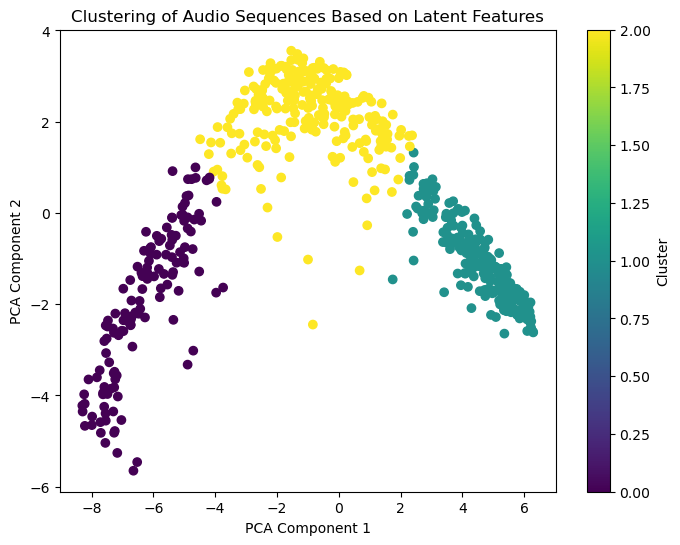

In [19]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Perform clustering
n_clusters = 3  # Adjust as needed
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(latent_features)

# Visualize using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(latent_features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis')
plt.title('Clustering of Audio Sequences Based on Latent Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()


3. Optional - Listen to Samples from Each Cluster


In [ ]:
import IPython.display as ipd

# Map from dataset index to original audio data
index = 0
for batch_data, _ in dataloader:
    batch_size = batch_data.size(0)
    for i in range(batch_size):
        # Get the label for this sample
        cluster_label = labels[index]
        print(f'Playing audio from Cluster {cluster_label}')
        y = audio_data[index]
        ipd.display(ipd.Audio(y, rate=16000))
        index += 1
        # Break after one sample per cluster
        if index >= len(audio_data):
            break
    if index >= len(audio_data):
        break
